# Machine Learning

In this file, instructions how to approach the challenge can be found.

We are going to work on different types of Machine Learning problems:

- **Regression Problem**: The goal is to predict delay of flights.
- **(Stretch) Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **(Stretch) Binary Classification**: The goal is to predict if the flight will be cancelled.

## Main Task: Regression Problem

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.  

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights **1 week in advance**.

In [1]:
import pandas as pd

flights = pd.read_csv('flights_2019_passengers.csv', delimiter=',')
flights = flights.drop('Unnamed: 0', axis=1)
flights.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,longest_add_gtime,no_name,dep_condition,arr_date,arr_condition,month,year,average_seats,average_passengers,avg_passenger_capacity_usage
0,2019-01-01,AA,AA_CODESHARE,AA,3044,OO,N761ND,3044,13930,ORD,...,NaN,NaN,Overcast,2019-01-01,Partly cloudy,1,2019,1002.000000,777.666667,0.776114
1,2019-01-01,AA,AA_CODESHARE,AA,5606,OH,N575NN,5606,13577,MYR,...,NaN,NaN,Cloudy,2019-01-01,Sunny,1,2019,6327.333333,4898.333333,0.774154
2,2019-01-01,AA,AA_CODESHARE,AA,5607,OH,N254PS,5607,10529,BDL,...,NaN,NaN,Sunny,2019-01-01,Sunny,1,2019,3516.500000,2697.250000,0.767027
3,2019-01-01,AA,AA_CODESHARE,AA,5607,OH,N254PS,5607,11278,DCA,...,NaN,NaN,Sunny,2019-01-01,Sunny,1,2019,3460.000000,2494.500000,0.720954
4,2019-01-01,AA,AA_CODESHARE,AA,5608,OH,N710PS,5608,11278,DCA,...,NaN,NaN,Sunny,2019-01-01,Partly cloudy,1,2019,1511.000000,847.333333,0.560777


In [2]:
# Outlier detection 

# Finding the IQR
percentile25 = flights['arr_delay'].quantile(0.25)
percentile75 = flights['arr_delay'].quantile(0.75)
iqr = percentile75 - percentile25

# Finding upper and lower limit
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

# Finding Outliers
flights[flights['arr_delay'] > upper_limit]
flights[flights['arr_delay'] < lower_limit]

# Trimming
flights = flights[(flights['arr_delay'] < upper_limit) & (flights['arr_delay'] > lower_limit)]
flights.shape

(106319, 50)

C:\Users\Irene\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Irene\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


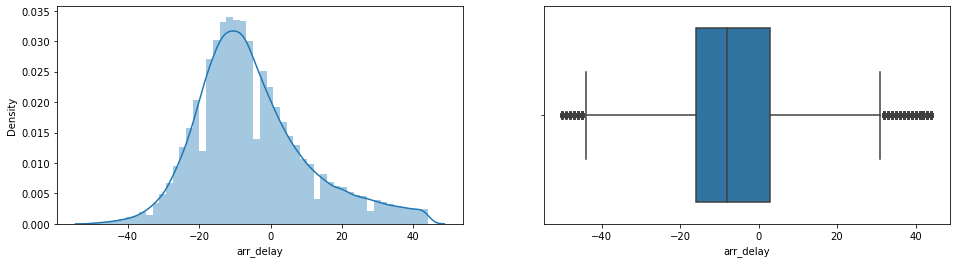

In [3]:
# Compare the plots after trimming
import matplotlib.pyplot as plt 
import seaborn as sns

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.distplot(flights['arr_delay'])
plt.subplot(1,2,2)
sns.boxplot(flights['arr_delay'])

plt.show()

In [4]:
import datetime as dt
flights['Month'] = pd.to_datetime(flights['fl_date']).dt.month

In [5]:
# Dropping non-relevant columns

new_flights = flights.drop(['branded_code_share','mkt_carrier','mkt_carrier_fl_num','op_unique_carrier',
                                'cancelled','cancellation_code','diverted','dup','first_dep_time', 
                                'total_add_gtime','longest_add_gtime', 'no_name', 'origin_airport_id',
                                'origin_city_name','dest_airport_id','dest_city_name', 'dep_time', 
                                'dep_delay','taxi_out', 'wheels_off', 'wheels_on', 'taxi_in','flights',
                               'fl_date','tail_num','op_carrier_fl_num','arr_date','average_seats',
                            'Month','year'], axis=1)
new_flights_delay = new_flights[['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay']]
new_flights = new_flights.drop(['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay'], axis=1)

new_flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106319 entries, 1 to 119999
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   mkt_unique_carrier            106319 non-null  object 
 1   origin                        106319 non-null  object 
 2   dest                          106319 non-null  object 
 3   crs_dep_time                  106319 non-null  int64  
 4   crs_arr_time                  106319 non-null  int64  
 5   arr_time                      106319 non-null  float64
 6   arr_delay                     106319 non-null  float64
 7   crs_elapsed_time              106319 non-null  int64  
 8   actual_elapsed_time           106319 non-null  float64
 9   air_time                      106319 non-null  float64
 10  distance                      106319 non-null  int64  
 11  dep_condition                 106319 non-null  object 
 12  arr_condition                 106319 non-nul

In [6]:
counts= new_flights['origin'].value_counts()
new_flights = new_flights[~new_flights['origin'].isin(counts[counts < 100].index)] 
# ~ is the negation operator.

In [7]:
counts= new_flights['dest'].value_counts()
new_flights = new_flights[~new_flights['dest'].isin(counts[counts < 100].index)] 
# ~ is the negation operator.

In [8]:
new_flights = new_flights.reset_index(drop=True)
new_flights

,mkt_unique_carrier,origin,dest,crs_dep_time,crs_arr_time,arr_time,arr_delay,crs_elapsed_time,actual_elapsed_time,air_time,distance,dep_condition,arr_condition,month,average_passengers,avg_passenger_capacity_usage
0,AA,MYR,CLT,2157,2311,2308.0,-3.0,74,70.0,40.0,157,Cloudy,Sunny,1,4898.333333,0.774154
1,AA,BDL,DCA,1151,1325,1331.0,6.0,94,79.0,69.0,313,Sunny,Sunny,1,2697.250000,0.767027
2,AA,DCA,BDL,1009,1126,1140.0,14.0,77,87.0,52.0,313,Sunny,Sunny,1,2494.500000,0.720954
3,AA,DCA,GSP,2000,2134,2122.0,-12.0,94,87.0,72.0,396,Sunny,Partly cloudy,1,847.333333,0.560777
4,AA,ORF,CLT,1215,1347,1333.0,-14.0,92,88.0,66.0,290,Partly cloudy,Sunny,1,4888.750000,0.798359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92037,WN,SEA,SMF,2210,2355,20.0,25.0,105,110.0,85.0,605,Overcast,Moderate rain,12,3812.333333,0.778199
92038,WN,SEA,SMF,615,800,815.0,15.0,105,111.0,92.0,605,Overcast,Moderate rain,12,3812.333333,0.778199
92039,WN,SEA,STL,935,1520,1526.0,6.0,225,235.0,209.0,1709,Overcast,Blizzard,12,2591.000000,0.819004
92040,WN,SFO,AUS,515,1040,1018.0,-22.0,205,178.0,164.0,1504,Moderate rain,Sunny,12,2269.636364,0.904795


In [9]:
def simple_weather(row):
    if row in ['Sunny', 'Clear']:
        return 'Sunny'
    
    elif row in ['Partly cloudy','Overcast','Cloudy']:
        return 'Cloudy'
    
    elif row in ['Torrential rain shower', 'Heavy rain', 'Heavy rain at times']:
        return 'Heavy_rain'

    elif row in ['Moderate rain', 'Moderate rain at times', 'Patchy rain possible',
                 'Light rain shower','Light drizzle','Light rain',
                 'Patchy light rain with thunder', 'Patchy light drizzle', 'Patchy light rain',
                 'Moderate or heavy rain with thunder']:
        return 'Light&Mod_rain'

    elif row in ['Moderate or heavy freezing rain']:
        return 'Freezing_rain'
    
    elif row in ['Mist','Fog', 'Freezing fog']:
        return 'Fog'
    
    elif row in ['Heavy snow', 'Moderate or heavy snow showers', 'Patchy heavy snow', 
                                  'Blizzard', 'Blowing snow', 'Ice pellets']:
        return 'Heavy_snow'
    
    elif row in ['Moderate snow', 'Moderate or heavy snow showers','Patchy moderate snow',
                                  'Moderate or heavy sleet', 'Moderate or heavy snow with thunder', 'Light snow', 'Light sleet', 'Patchy light snow', 'Light sleet showers',
                                  'Patchy sleet possible', 'Light snow showers', 
                                  'Patchy light snow with thunder', 'Patchy snow possible']:
        return 'Light&Mod_snow'
    

    elif row in ['Thundery outbreaks possible']:
        return 'Thunder'
    
'''
    elif row in ['Patchy rain possible','Light rain shower','Light drizzle','Light rain',
                                  'Patchy light rain with thunder', 'Patchy light drizzle', 'Patchy light rain']:
        return 'Light_rain
    elif row in ['Light snow', 'Light sleet', 'Patchy light snow', 'Light sleet showers',
                                  'Patchy sleet possible', 'Light snow showers', 
                                  'Patchy light snow with thunder', 'Patchy snow possible']:
        return 'Light_snow
'''
    

"\n    elif row in ['Patchy rain possible','Light rain shower','Light drizzle','Light rain',\n                                  'Patchy light rain with thunder', 'Patchy light drizzle', 'Patchy light rain']:\n        return 'Light_rain\n    elif row in ['Light snow', 'Light sleet', 'Patchy light snow', 'Light sleet showers',\n                                  'Patchy sleet possible', 'Light snow showers', \n                                  'Patchy light snow with thunder', 'Patchy snow possible']:\n        return 'Light_snow\n"

In [10]:
new_flights['weather_origin_simple'] = new_flights.apply(lambda row: simple_weather(row['dep_condition']), axis=1)
new_flights['weather_origin_simple'].value_counts()

Sunny             48520
Cloudy            26589
Light&Mod_rain    10576
Light&Mod_snow     1365
Heavy_snow         1049
Fog                 824
Heavy_rain          277
Thunder              65
Freezing_rain        27
Name: weather_origin_simple, dtype: int64

In [11]:
wt_counts= new_flights['weather_origin_simple'].value_counts()
new_flights = new_flights[~new_flights['weather_origin_simple'].isin(wt_counts[wt_counts < 100].index)] 
# ~ is the negation operator.
new_flights = new_flights.reset_index(drop=True)
new_flights

,mkt_unique_carrier,origin,dest,crs_dep_time,crs_arr_time,arr_time,arr_delay,crs_elapsed_time,actual_elapsed_time,air_time,distance,dep_condition,arr_condition,month,average_passengers,avg_passenger_capacity_usage,weather_origin_simple
0,AA,MYR,CLT,2157,2311,2308.0,-3.0,74,70.0,40.0,157,Cloudy,Sunny,1,4898.333333,0.774154,Cloudy
1,AA,BDL,DCA,1151,1325,1331.0,6.0,94,79.0,69.0,313,Sunny,Sunny,1,2697.250000,0.767027,Sunny
2,AA,DCA,BDL,1009,1126,1140.0,14.0,77,87.0,52.0,313,Sunny,Sunny,1,2494.500000,0.720954,Sunny
3,AA,DCA,GSP,2000,2134,2122.0,-12.0,94,87.0,72.0,396,Sunny,Partly cloudy,1,847.333333,0.560777,Sunny
4,AA,ORF,CLT,1215,1347,1333.0,-14.0,92,88.0,66.0,290,Partly cloudy,Sunny,1,4888.750000,0.798359,Cloudy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91945,WN,SEA,SMF,2210,2355,20.0,25.0,105,110.0,85.0,605,Overcast,Moderate rain,12,3812.333333,0.778199,Cloudy
91946,WN,SEA,SMF,615,800,815.0,15.0,105,111.0,92.0,605,Overcast,Moderate rain,12,3812.333333,0.778199,Cloudy
91947,WN,SEA,STL,935,1520,1526.0,6.0,225,235.0,209.0,1709,Overcast,Blizzard,12,2591.000000,0.819004,Cloudy
91948,WN,SFO,AUS,515,1040,1018.0,-22.0,205,178.0,164.0,1504,Moderate rain,Sunny,12,2269.636364,0.904795,Light&Mod_rain


In [12]:
new_flights['weather_dest_simple'] = new_flights.apply(lambda row: simple_weather(row['arr_condition']), axis=1)
new_flights['weather_dest_simple'].value_counts()

Sunny             47951
Cloudy            26649
Light&Mod_rain    10759
Light&Mod_snow     1394
Heavy_snow         1349
Fog                 835
Heavy_rain          225
Thunder              88
Freezing_rain        28
Name: weather_dest_simple, dtype: int64

In [13]:
wt_counts= new_flights['weather_dest_simple'].value_counts()
new_flights = new_flights[~new_flights['weather_dest_simple'].isin(wt_counts[wt_counts < 100].index)] 
# ~ is the negation operator.
new_flights = new_flights.reset_index(drop=True)
new_flights

,mkt_unique_carrier,origin,dest,crs_dep_time,crs_arr_time,arr_time,arr_delay,crs_elapsed_time,actual_elapsed_time,air_time,distance,dep_condition,arr_condition,month,average_passengers,avg_passenger_capacity_usage,weather_origin_simple,weather_dest_simple
0,AA,MYR,CLT,2157,2311,2308.0,-3.0,74,70.0,40.0,157,Cloudy,Sunny,1,4898.333333,0.774154,Cloudy,Sunny
1,AA,BDL,DCA,1151,1325,1331.0,6.0,94,79.0,69.0,313,Sunny,Sunny,1,2697.250000,0.767027,Sunny,Sunny
2,AA,DCA,BDL,1009,1126,1140.0,14.0,77,87.0,52.0,313,Sunny,Sunny,1,2494.500000,0.720954,Sunny,Sunny
3,AA,DCA,GSP,2000,2134,2122.0,-12.0,94,87.0,72.0,396,Sunny,Partly cloudy,1,847.333333,0.560777,Sunny,Cloudy
4,AA,ORF,CLT,1215,1347,1333.0,-14.0,92,88.0,66.0,290,Partly cloudy,Sunny,1,4888.750000,0.798359,Cloudy,Sunny
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91829,WN,SEA,SMF,2210,2355,20.0,25.0,105,110.0,85.0,605,Overcast,Moderate rain,12,3812.333333,0.778199,Cloudy,Light&Mod_rain
91830,WN,SEA,SMF,615,800,815.0,15.0,105,111.0,92.0,605,Overcast,Moderate rain,12,3812.333333,0.778199,Cloudy,Light&Mod_rain
91831,WN,SEA,STL,935,1520,1526.0,6.0,225,235.0,209.0,1709,Overcast,Blizzard,12,2591.000000,0.819004,Cloudy,Heavy_snow
91832,WN,SFO,AUS,515,1040,1018.0,-22.0,205,178.0,164.0,1504,Moderate rain,Sunny,12,2269.636364,0.904795,Light&Mod_rain,Sunny


### Feature Engineering

Feature engineering will play a crucial role in this problems. We have only very little attributes so we need to create some features that will have some predictive power.

- weather: we can use some weather API to look for the weather in time of the scheduled departure and scheduled arrival.
- statistics (avg, mean, median, std, min, max...): we can take a look at previous delays and compute descriptive statistics
- airports encoding: we need to think about what to do with the airports and other categorical variables
- time of the day: the delay probably depends on the airport traffic which varies during the day.
- airport traffic
- unsupervised learning as feature engineering?
- **what are the additional options?**: Think about what we could do more to improve the model.

In [ ]:
'''
from pandas_profiling import ProfileReport
profile = ProfileReport(new_flights, title ="Pandas Profiling Report")
profile
'''

In [14]:
new_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91834 entries, 0 to 91833
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   mkt_unique_carrier            91834 non-null  object 
 1   origin                        91834 non-null  object 
 2   dest                          91834 non-null  object 
 3   crs_dep_time                  91834 non-null  int64  
 4   crs_arr_time                  91834 non-null  int64  
 5   arr_time                      91834 non-null  float64
 6   arr_delay                     91834 non-null  float64
 7   crs_elapsed_time              91834 non-null  int64  
 8   actual_elapsed_time           91834 non-null  float64
 9   air_time                      91834 non-null  float64
 10  distance                      91834 non-null  int64  
 11  dep_condition                 91834 non-null  object 
 12  arr_condition                 91834 non-null  object 
 13  m

In [15]:
y = new_flights['arr_delay']
X_category = new_flights[['mkt_unique_carrier','weather_origin_simple','weather_dest_simple','origin','dest']]
X = new_flights.drop(['arr_delay','mkt_unique_carrier','origin','dest','dep_condition','arr_condition','weather_origin_simple','weather_dest_simple'], axis=1)

In [16]:
X_col = X.columns

In [17]:
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)

In [18]:
# transforming an array back to a data-frame preserves column labels
X_scaled = pd.DataFrame(X_scaled, columns = X_col)

In [19]:
X_scaled = X_scaled.join(X_category)

In [21]:
X_scaled

,crs_dep_time,crs_arr_time,arr_time,crs_elapsed_time,actual_elapsed_time,air_time,distance,month,average_passengers,avg_passenger_capacity_usage,mkt_unique_carrier,weather_origin_simple,weather_dest_simple,origin,dest
0,1.705225,1.602566,1.607600,-0.987479,-0.948610,-1.072136,-1.152645,-1.597201,0.065070,-0.610478,AA,Cloudy,Sunny,MYR,CLT
1,-0.342646,-0.291919,-0.253435,-0.707917,-0.822538,-0.654715,-0.885821,-1.597201,-0.583839,-0.700673,AA,Sunny,Sunny,BDL,DCA
2,-0.631709,-0.674274,-0.617260,-0.945544,-0.710475,-0.899410,-0.885821,-1.597201,-0.643612,-1.283697,AA,Sunny,Sunny,DCA,BDL
3,1.385627,1.262481,1.253299,-0.707917,-0.710475,-0.611534,-0.743856,-1.597201,-1.129219,-3.310634,AA,Sunny,Cloudy,DCA,GSP
4,-0.212364,-0.249649,-0.249625,-0.735873,-0.696467,-0.697897,-0.925160,-1.597201,0.062245,-0.304188,AA,Cloudy,Sunny,ORF,CLT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91829,1.813115,1.687106,-2.750688,-0.554159,-0.388292,-0.424414,-0.386380,1.595450,-0.255097,-0.559293,WN,Cloudy,Light&Mod_rain,SEA,SMF
91830,-1.433758,-1.300645,-1.236336,-0.554159,-0.374284,-0.323658,-0.386380,1.595450,-0.255097,-0.559293,WN,Cloudy,Light&Mod_rain,SEA,SMF
91831,-0.782348,0.082751,0.118010,1.123209,1.362704,1.360419,1.501914,1.595450,-0.615163,-0.042941,WN,Cloudy,Heavy_snow,SEA,STL
91832,-1.637324,-0.839513,-0.849652,0.843648,0.564250,0.712697,1.151280,1.595450,-0.709905,1.042688,WN,Light&Mod_rain,Sunny,SFO,AUS


In [22]:
# One hot encoding for origin and unique_carrier and weather
# are these too many columns now? - to discuss

onehot_origin = pd.get_dummies(X_scaled[['origin','dest']])
X_scaled = X_scaled.drop('origin', axis=1)
X_scaled = X_scaled.drop('dest', axis=1)
X_scaled = X_scaled.join(onehot_origin)

onehot_carrier = pd.get_dummies(X_scaled['mkt_unique_carrier'])
X_scaled = X_scaled.drop('mkt_unique_carrier', axis=1)
X_scaled = X_scaled.join(onehot_carrier)

onehot_weather = pd.get_dummies(X_scaled[['weather_origin_simple','weather_dest_simple']])
X_scaled = X_scaled.drop(['weather_origin_simple','weather_dest_simple'], axis=1)
X_scaled = X_scaled.join(onehot_weather)


### Feature Selection / Dimensionality Reduction

We need to apply different selection techniques to find out which one will be the best for our problems.

- Original Features vs. PCA conponents?

##### variance threshold

In [23]:
X_scaled

,crs_dep_time,crs_arr_time,arr_time,crs_elapsed_time,actual_elapsed_time,air_time,distance,month,average_passengers,avg_passenger_capacity_usage,...,weather_origin_simple_Light&Mod_rain,weather_origin_simple_Light&Mod_snow,weather_origin_simple_Sunny,weather_dest_simple_Cloudy,weather_dest_simple_Fog,weather_dest_simple_Heavy_rain,weather_dest_simple_Heavy_snow,weather_dest_simple_Light&Mod_rain,weather_dest_simple_Light&Mod_snow,weather_dest_simple_Sunny
0,1.705225,1.602566,1.607600,-0.987479,-0.948610,-1.072136,-1.152645,-1.597201,0.065070,-0.610478,...,0,0,0,0,0,0,0,0,0,1
1,-0.342646,-0.291919,-0.253435,-0.707917,-0.822538,-0.654715,-0.885821,-1.597201,-0.583839,-0.700673,...,0,0,1,0,0,0,0,0,0,1
2,-0.631709,-0.674274,-0.617260,-0.945544,-0.710475,-0.899410,-0.885821,-1.597201,-0.643612,-1.283697,...,0,0,1,0,0,0,0,0,0,1
3,1.385627,1.262481,1.253299,-0.707917,-0.710475,-0.611534,-0.743856,-1.597201,-1.129219,-3.310634,...,0,0,1,1,0,0,0,0,0,0
4,-0.212364,-0.249649,-0.249625,-0.735873,-0.696467,-0.697897,-0.925160,-1.597201,0.062245,-0.304188,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91829,1.813115,1.687106,-2.750688,-0.554159,-0.388292,-0.424414,-0.386380,1.595450,-0.255097,-0.559293,...,0,0,0,0,0,0,0,1,0,0
91830,-1.433758,-1.300645,-1.236336,-0.554159,-0.374284,-0.323658,-0.386380,1.595450,-0.255097,-0.559293,...,0,0,0,0,0,0,0,1,0,0
91831,-0.782348,0.082751,0.118010,1.123209,1.362704,1.360419,1.501914,1.595450,-0.615163,-0.042941,...,0,0,0,0,0,0,1,0,0,0
91832,-1.637324,-0.839513,-0.849652,0.843648,0.564250,0.712697,1.151280,1.595450,-0.709905,1.042688,...,1,0,0,0,0,0,0,0,0,1


In [24]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(0.1)
X_transform = vt.fit_transform(X_scaled)

In [25]:
X_transform.shape

(91834, 20)

In [28]:
# columns we have selected
# get_support() is method of VarianceThreshold and stores boolean of each variable in the numpy array.
selected_columns = X_scaled.columns[vt.get_support()]
# transforming an array back to a data-frame preserves column labels
X_transform = pd.DataFrame(X_transform, columns = selected_columns)

In [29]:
X_transform

,crs_dep_time,crs_arr_time,arr_time,crs_elapsed_time,actual_elapsed_time,air_time,distance,month,average_passengers,avg_passenger_capacity_usage,AA,DL,UA,WN,weather_origin_simple_Cloudy,weather_origin_simple_Light&Mod_rain,weather_origin_simple_Sunny,weather_dest_simple_Cloudy,weather_dest_simple_Light&Mod_rain,weather_dest_simple_Sunny
0,1.705225,1.602566,1.607600,-0.987479,-0.948610,-1.072136,-1.152645,-1.597201,0.065070,-0.610478,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,-0.342646,-0.291919,-0.253435,-0.707917,-0.822538,-0.654715,-0.885821,-1.597201,-0.583839,-0.700673,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,-0.631709,-0.674274,-0.617260,-0.945544,-0.710475,-0.899410,-0.885821,-1.597201,-0.643612,-1.283697,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1.385627,1.262481,1.253299,-0.707917,-0.710475,-0.611534,-0.743856,-1.597201,-1.129219,-3.310634,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,-0.212364,-0.249649,-0.249625,-0.735873,-0.696467,-0.697897,-0.925160,-1.597201,0.062245,-0.304188,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91829,1.813115,1.687106,-2.750688,-0.554159,-0.388292,-0.424414,-0.386380,1.595450,-0.255097,-0.559293,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
91830,-1.433758,-1.300645,-1.236336,-0.554159,-0.374284,-0.323658,-0.386380,1.595450,-0.255097,-0.559293,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
91831,-0.782348,0.082751,0.118010,1.123209,1.362704,1.360419,1.501914,1.595450,-0.615163,-0.042941,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
91832,-1.637324,-0.839513,-0.849652,0.843648,0.564250,0.712697,1.151280,1.595450,-0.709905,1.042688,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [32]:
import numpy as np 

# step 1
X_corr = X_transform.corr().abs()

# step 2
indices = np.where(X_corr > 0.85) 
indices = [(X_corr.index[x], X.columns[y]) 
for x, y in zip(*indices)
    if x != y and x < y]

# step 3
for idx in indices: #each pair
    try:
        X_transform.drop(idx[1], axis = 1, inplace=True)
    except KeyError:
        pass

In [33]:
print(indices)

[('crs_arr_time', 'arr_time'), ('crs_elapsed_time', 'actual_elapsed_time'), ('crs_elapsed_time', 'air_time'), ('crs_elapsed_time', 'distance'), ('actual_elapsed_time', 'air_time'), ('actual_elapsed_time', 'distance'), ('air_time', 'distance')]


In [35]:
X_transform.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91834 entries, 0 to 91833
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   crs_dep_time                          91834 non-null  float64
 1   crs_arr_time                          91834 non-null  float64
 2   crs_elapsed_time                      91834 non-null  float64
 3   month                                 91834 non-null  float64
 4   average_passengers                    91834 non-null  float64
 5   avg_passenger_capacity_usage          91834 non-null  float64
 6   AA                                    91834 non-null  float64
 7   DL                                    91834 non-null  float64
 8   UA                                    91834 non-null  float64
 9   WN                                    91834 non-null  float64
 10  weather_origin_simple_Cloudy          91834 non-null  float64
 11  weather_origin_

In [38]:
# Forward Regression 

from sklearn.feature_selection import f_regression, SelectKBest
skb = SelectKBest(f_regression, k=15)
X = skb.fit_transform(X_transform, y)

In [40]:
# this will give us the position of top 10 columns
skb.get_support()
# column names
X_transform.columns[skb.get_support()]
X = pd.DataFrame(X,columns=X_transform.columns[skb.get_support()])

In [41]:
# X_transform and X are the same data as I used k=15 which is the maximum number of columns in X 
X.shape

(91834, 15)

### Modeling

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

In [57]:
result = pd.DataFrame()

#####  #1. Linear Regression

In [42]:
import statsmodels.api as sm
X_con = sm.add_constant(X) # adding a constant

C:\Users\Irene\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [43]:
y = list(y)

lin_reg = sm.OLS(y,X_con)
# performing the regression
# and fitting the model
result = sm.OLS(y, X_con).fit()
 
# printing the summary table
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     205.4
Date:                Thu, 04 Aug 2022   Prob (F-statistic):               0.00
Time:                        17:44:14   Log-Likelihood:            -3.8283e+05
No. Observations:               91834   AIC:                         7.657e+05
Df Residuals:                   91818   BIC:                         7.659e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [44]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X, y)

regressor.score(X,y) # R-squared

0.03246785380615724

#####  #2. Multinomial Logistic Regression

In [ ]:
# Step 1: Import Packages, Functions, and Classes
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Step 2: Get Data - We already have X, y

#### 2. Polynomial regression?

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [ ]:
# Fitting Linear Regression to the dataset
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)

# Visualizing the Linear Regression results
def viz_linear():
    plt.scatter(X, y, color='red')
    plt.plot(X, lin_reg.predict(X), color='blue')
    plt.title('Truth or Bluff (Linear Regression)')
    plt.xlabel('Position level')
    plt.ylabel('Salary')
    plt.show()
    return
viz_linear()

In [ ]:
'''
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
'''

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [ ]:
'''
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Step 3: Create a Model and Train It
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
'''

The “saga” solver 7 is a variant of “sag” that also supports the non-smooth penalty="l1". This is therefore the solver of choice for sparse multinomial logistic regression. It is also the only solver that supports penalty="elasticnet".

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty="l1", max_iter=200, multi_class = 'multinomial', solver='saga')
# training the model
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

#####  #3. Random Forest

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=42)


In [54]:
from sklearn.ensemble import RandomForestRegressor # Import Random Forest Regressory
regr = RandomForestRegressor(max_depth=20)
regr.fit(X_train, y_train)


RandomForestRegressor(max_depth=20)

In [55]:
y_pred = regr.predict(X_test)

In [66]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# Mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred, squared=False)

# R-squared scores
r2 = r2_score(y_test, y_pred)

print('Mean Absolute Error:', round(mae, 2))
print('Mean Squared Error:', round(mse, 2))
print('R-squared scores:', round(r2, 2))

Mean Absolute Error: 11.49
Mean Squared Error: 14.94
R-squared scores: 0.11


In [58]:
result['Random_Forest'] = y_pred.tolist()

Random_Forest   -4.572819
dtype: float64

#####  #4. Naive Bayes

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, random_state=42)

from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB()

In [70]:
y_pred = clf.predict(X_test)

In [71]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

mse = mean_squared_error(y_test, y_pred, squared=False)
print("MSE: {:.2f}".format(mse))

Accuracy: 0.12%
MSE: 40.13


#####  #5. SVM

In [ ]:
from sklearn import preprocessing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, random_state=42)

X_train_scaled = transform(X_train)
X_test_scaled = transform(X_test)

In [ ]:
from sklearn.svm import SVC
clf = SVC(kernel= 'poly', random_state=0)  #use the Polynomial kernel (polynomial linear regression)
clf.fit(X_train, y_train)

In [ ]:
# Predict the Test set results
y_pred = clf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
# use rbf kernel
clf_rbf = SVC(kernel= 'rbf', random_state=0)

#####  #6. XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [ ]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

### Evaluation

You have data from 2018 and 2019 to develop models. Use different evaluation metrics for each problem and compare the performance of different models.

You are required to predict delays on **out of sample** data from **first 7 days (1st-7th) of January 2020** and to share the file with LighthouseLabs. Sample submission can be found in the file **_sample_submission.csv_**

In [ ]:
testset = pd.read_csv('flights_test.txt', delimiter = ',')
testset.head()

======================================================================
## Stretch Tasks

### Multiclass Classification

The target variables are **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY**. We need to do additional transformations because these variables are not binary but continuos. For each flight that was delayed, we need to have one of these variables as 1 and others 0.

It can happen that we have two types of delays with more than 0 minutes. In this case, take the bigger one as 1 and others as 0.

### Binary Classification

The target variable is **CANCELLED**. The main problem here is going to be huge class imbalance. We have only very little cancelled flights with comparison to all flights. It is important to do the right sampling before training and to choose correct evaluation metrics.